In [66]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import cv2
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report,confusion_matrix

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from random import shuffle

In [115]:
def label_img(img):
    word_label = img.split('_')[0]
    if word_label == '0' : return 0
    elif word_label == '1' : return 1
    elif word_label == '6' : return 2
#     elif word_label == '9' : return 9
    elif word_label == '12' : return 3

In [68]:
def load_df(dir_name:str, size:int, grayscale:bool):
    data = []
    labels = []
    for img in os.listdir(dir_name):
        label = label_img(img)
        path = os.path.join(dir_name,img)
        if grayscale:
            img = cv2.resize(cv2.imread(path, cv2.IMREAD_GRAYSCALE),(2*size,size))
        else:
            img = cv2.resize(cv2.imread(path),(2*size,size))
        data.append(np.array(np.array(img[0:size,0:size]).flatten()))
        labels.append(label)
    
    cols = []
    num = size*size
    if not grayscale:
        num *=3
    for i in range(num):
        cols.append("pixel_"+str(i))
    data = pd.DataFrame(data, columns=cols)
    data = data/255
    data['label'] = labels
    data = data.sample(frac=1,random_state=0)
    return data


In [116]:
def train_test_split(data, samples_number :int, size:int, graysacle:bool):
    test = data.groupby('label').get_group(0).sample(n = samples_number)
    test = test.append(data.groupby('label').get_group(1).sample(n = samples_number))
    try:
        test = test.append(data.groupby('label').get_group(2).sample(n = samples_number))
    except:
        pass
    try:
        test = test.append(data.groupby('label').get_group(9).sample(n = samples_number))
    except:
        pass
    try:
        test = test.append(data.groupby('label').get_group(3).sample(n = samples_number))
    except:
        pass
    train = data[ ~data.index.isin(test.index) ]
    train_data = train.drop('label',axis=1)
    train_target = train['label']

    test_data = test.drop('label',axis=1)
    test_target = test['label']
    
    train_data_reshaped = []
    test_data_reshaped = []
    
    shape = (size,size)
    if not graysacle:
        shape = (size,size,3)
        
    for i in range(len(train_data)):
        t = train_data.iloc[i].values.reshape(shape)
        t = np.array(t)
        train_data_reshaped.append(t)

    for i in range(len(test_data)):
        t = test_data.iloc[i].values.reshape(shape)
        t = np.array(t)
        test_data_reshaped.append(t)
        
    train_data_reshaped = np.array(train_data_reshaped)
    test_data_reshaped = np.array(test_data_reshaped)
    
    if graysacle:
        test_data_reshaped = np.expand_dims(test_data_reshaped,axis=-1)
        train_data_reshaped = np.expand_dims(train_data_reshaped,axis=-1)
    
    return train_data_reshaped, train_target,test_data_reshaped,test_target

# Ptolemy I

In [72]:
dir_n = r'ptolemy I'
size = 70
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 2
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

In [73]:
len(df)

2267

In [74]:
df.head()

,pixel_0,pixel_1,pixel_2,pixel_3,pixel_4,pixel_5,pixel_6,pixel_7,pixel_8,pixel_9,...,pixel_4891,pixel_4892,pixel_4893,pixel_4894,pixel_4895,pixel_4896,pixel_4897,pixel_4898,pixel_4899,label
70,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1171,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
1246,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
971,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0
361,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0


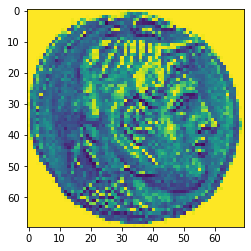

In [75]:
plt.imshow(x_train[0].reshape((size,size)))

In [91]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(70, 70, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2))
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_20 (Conv2D)           (None, 68, 68, 32)        320       
_________________________________________________________________
max_pooling2d_20 (MaxPooling (None, 34, 34, 32)        0         
_________________________________________________________________
conv2d_21 (Conv2D)           (None, 32, 32, 42)        12138     
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 16, 16, 42)        0         
_________________________________________________________________
conv2d_22 (Conv2D)           (None, 14, 14, 52)        19708     
_________________________________________________________________
max_pooling2d_22 (MaxPooling (None, 7, 7, 52)          0         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 5, 5, 62)         

In [92]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=15,batch_size = 18)

Epoch 1/15
101/101 [==============================] - 5s 46ms/step - loss: 0.5189 - accuracy: 0.7499
Epoch 2/15
101/101 [==============================] - 5s 52ms/step - loss: 0.0734 - accuracy: 0.9791
Epoch 3/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0546 - accuracy: 0.9873
Epoch 4/15
101/101 [==============================] - 5s 49ms/step - loss: 0.0418 - accuracy: 0.9901
Epoch 5/15
101/101 [==============================] - 5s 50ms/step - loss: 0.0410 - accuracy: 0.9901
Epoch 6/15
101/101 [==============================] - 5s 48ms/step - loss: 0.0288 - accuracy: 0.9945
Epoch 7/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0243 - accuracy: 0.9950
Epoch 8/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0186 - accuracy: 0.9950
Epoch 9/15
101/101 [==============================] - 5s 46ms/step - loss: 0.0170 - accuracy: 0.9961
Epoch 10/15
101/101 [==============================] - 5s 47ms/step - loss: 0.0116 - accura

15/15 - 0s - loss: 0.0566 - accuracy: 0.9889
              precision    recall  f1-score   support

           0       0.98      1.00      0.99       226
           1       1.00      0.98      0.99       226

    accuracy                           0.99       452
   macro avg       0.99      0.99      0.99       452
weighted avg       0.99      0.99      0.99       452



Text(33.0, 0.5, 'Actual')

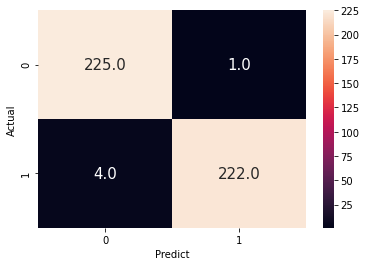

In [93]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# Ptolemy I VI XII

In [122]:
dir_n = r'mixed'
size = 150
is_gray = True
df = load_df(dir_n,size,is_gray)
class_num = 4
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

In [123]:
len(df)

3665

In [126]:
model = models.Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(size, size, 1)))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(42, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(52, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Conv2D(62, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))


model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(4))
model.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_48 (Conv2D)           (None, 148, 148, 32)      320       
_________________________________________________________________
max_pooling2d_48 (MaxPooling (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 72, 72, 42)        12138     
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 36, 36, 42)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 34, 34, 52)        19708     
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 17, 17, 52)        0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 15, 15, 62)      

In [127]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=29,batch_size = 29)

Epoch 1/29
102/102 [==============================] - 33s 325ms/step - loss: 1.0161 - accuracy: 0.5554
Epoch 2/29
102/102 [==============================] - 35s 346ms/step - loss: 0.4100 - accuracy: 0.8507
Epoch 3/29
102/102 [==============================] - 34s 335ms/step - loss: 0.3061 - accuracy: 0.8902
Epoch 4/29
102/102 [==============================] - 34s 334ms/step - loss: 0.2148 - accuracy: 0.9304
Epoch 5/29
102/102 [==============================] - 34s 334ms/step - loss: 0.1737 - accuracy: 0.9417
Epoch 6/29
102/102 [==============================] - 34s 336ms/step - loss: 0.1440 - accuracy: 0.9567
Epoch 7/29
102/102 [==============================] - 34s 338ms/step - loss: 0.0899 - accuracy: 0.9707
Epoch 8/29
102/102 [==============================] - 35s 339ms/step - loss: 0.0605 - accuracy: 0.9795
Epoch 9/29
102/102 [==============================] - 36s 353ms/step - loss: 0.0833 - accuracy: 0.9707
Epoch 10/29
102/102 [==============================] - 38s 368ms/step - l

23/23 - 2s - loss: 0.5777 - accuracy: 0.9290
              precision    recall  f1-score   support

           0       0.96      0.98      0.97       183
           1       0.95      0.96      0.95       183
           2       0.91      0.87      0.89       183
           3       0.90      0.90      0.90       183

    accuracy                           0.93       732
   macro avg       0.93      0.93      0.93       732
weighted avg       0.93      0.93      0.93       732



Text(33.0, 0.5, 'Actual')

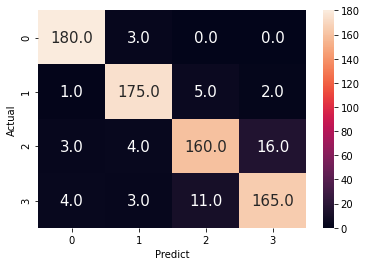

In [128]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")

# VGG and ResNet

In [139]:
dir_n = r'mixed'
size = 224
is_gray = False
df = load_df(dir_n,size,is_gray)
class_num = 4
samples = int(np.floor(len(df)*0.2)//class_num)
x_train,y_train,x_test,y_test = train_test_split(df, samples,size,is_gray)

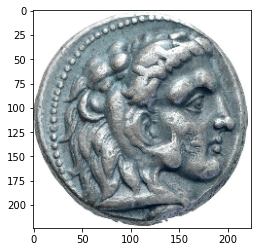

In [140]:
plt.imshow(x_train[0])

In [141]:
model = tf.keras.applications.resnet50.ResNet50(
    weights=None,
    input_tensor=None,
    input_shape=None,
    pooling=None,
    classes=4,
)
model.summary()


Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
___________________________________________________________________________________________

                                                                 conv4_block4_3_bn[0][0]          
__________________________________________________________________________________________________
conv4_block4_out (Activation)   (None, 14, 14, 1024) 0           conv4_block4_add[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_conv (Conv2D)    (None, 14, 14, 256)  262400      conv4_block4_out[0][0]           
__________________________________________________________________________________________________
conv4_block5_1_bn (BatchNormali (None, 14, 14, 256)  1024        conv4_block5_1_conv[0][0]        
__________________________________________________________________________________________________
conv4_block5_1_relu (Activation (None, 14, 14, 256)  0           conv4_block5_1_bn[0][0]          
__________________________________________________________________________________________________
conv4_bloc

In [142]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
history = model.fit(x_train, y_train, epochs=10,batch_size = 10)

Epoch 1/10
  2/294 [..............................] - ETA: 2:33:43 - loss: 1.5167 - accuracy: 0.1500

KeyboardInterrupt: 

23/23 - 2s - loss: 0.5021 - accuracy: 0.9126
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       183
           1       0.98      0.92      0.95       183
           2       0.85      0.88      0.87       183
           3       0.88      0.86      0.87       183

    accuracy                           0.91       732
   macro avg       0.91      0.91      0.91       732
weighted avg       0.91      0.91      0.91       732



Text(33.0, 0.5, 'Actual')

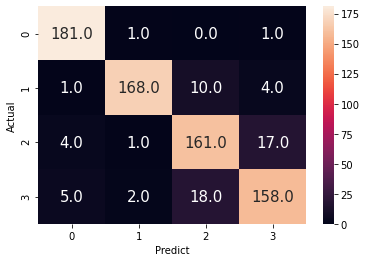

In [138]:
test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)
y_pred = np.argmax(model.predict(x_test),axis=-1)
print (classification_report(y_test,y_pred))
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm,annot=True,annot_kws = {'size':15},fmt=".1f")
plt.xlabel("Predict")
plt.ylabel("Actual")